The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France).

The dataset provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data.

In [2]:
import pandas as pd
%matplotlib inline

In [9]:
data = pd.read_csv('monthly_champagne_sales.csv', index_col = 0, parse_dates = True, 
                   date_parser = lambda dates: pd.datetime.strptime(dates, '%Y-%m'), squeeze = True)
data.head()

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Name: Sales, dtype: int64

final year of data will be used to validate the final model.

In [10]:
data.tail()

Month
1972-05-01    4618
1972-06-01    5312
1972-07-01    4298
1972-08-01    1413
1972-09-01    5877
Name: Sales, dtype: int64

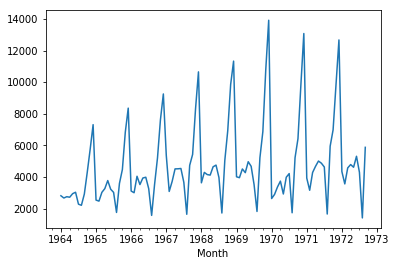

In [11]:
data.plot()

Some observations from the plot include:

There may be an increasing trend of sales over time.
There appears to be systematic seasonality to the sales for each year.
The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).
There do not appear to be any obvious outliers.
The seasonality suggests that the series is almost certainly non-stationary.


In [12]:
len(data)

105

In [13]:
split_point = len(data) -12
split_point

93

In [14]:
train, test = data[:split_point], data[split_point:]
print(train.shape)
print(test.shape)

(93,)
(12,)


/Users/amit.panda03/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


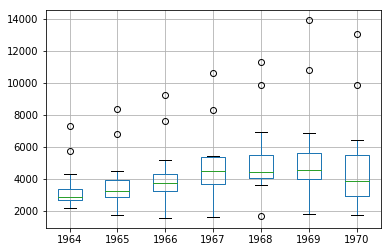

In [18]:
groups = data['1964':'1970'].groupby(pd.TimeGrouper('A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()

Analysis of the time series data assumes that we are working with a stationary time series.

The time series is almost certainly non-stationary. We can make it stationary this by first differencing the series and using a statistical test to confirm that the result is stationary.

The seasonality in the series is seemingly year-to-year. Seasonal data can be differenced by subtracting the observation from the same time in the previous cycle, in this case the same month in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.

## Deseasonalization

In [26]:
from statsmodels.tsa.stattools import adfuller

In [29]:
data.values

array([ 2815,  2672,  2755,  2721,  2946,  3036,  2282,  2212,  2922,
        4301,  5764,  7312,  2541,  2475,  3031,  3266,  3776,  3230,
        3028,  1759,  3595,  4474,  6838,  8357,  3113,  3006,  4047,
        3523,  3937,  3986,  3260,  1573,  3528,  5211,  7614,  9254,
        5375,  3088,  3718,  4514,  4520,  4539,  3663,  1643,  4739,
        5428,  8314, 10651,  3633,  4292,  4154,  4121,  4647,  4753,
        3965,  1723,  5048,  6922,  9858, 11331,  4016,  3957,  4510,
        4276,  4968,  4677,  3523,  1821,  5222,  6872, 10803, 13916,
        2639,  2899,  3370,  3740,  2927,  3986,  4217,  1738,  5221,
        6424,  9842, 13076,  3934,  3162,  4286,  4676,  5010,  4874,
        4633,  1659,  5951,  6981,  9851, 12670,  4348,  3564,  4577,
        4788,  4618,  5312,  4298,  1413,  5877])

In [27]:
#create differenced series

def difference(data,interval=1):
    diff = list()
    for i in range(interval,len(data)):
        value = data[i] - data[i-interval]
        diff.append(value)
    return pd.Series(diff)

In [30]:
months = 12
stationary = difference(data.values, months)

In [32]:
stationary.index = data.index[months:]

In [33]:
stationary

Month
1965-01-01    -274
1965-02-01    -197
1965-03-01     276
1965-04-01     545
1965-05-01     830
1965-06-01     194
1965-07-01     746
1965-08-01    -453
1965-09-01     673
1965-10-01     173
1965-11-01    1074
1965-12-01    1045
1966-01-01     572
1966-02-01     531
1966-03-01    1016
1966-04-01     257
1966-05-01     161
1966-06-01     756
1966-07-01     232
1966-08-01    -186
1966-09-01     -67
1966-10-01     737
1966-11-01     776
1966-12-01     897
1967-01-01    2262
1967-02-01      82
1967-03-01    -329
1967-04-01     991
1967-05-01     583
1967-06-01     553
              ... 
1970-04-01    -536
1970-05-01   -2041
1970-06-01    -691
1970-07-01     694
1970-08-01     -83
1970-09-01      -1
1970-10-01    -448
1970-11-01    -961
1970-12-01    -840
1971-01-01    1295
1971-02-01     263
1971-03-01     916
1971-04-01     936
1971-05-01    2083
1971-06-01     888
1971-07-01     416
1971-08-01     -79
1971-09-01     730
1971-10-01     557
1971-11-01       9
1971-12-01    -406
1972-0

In [35]:
result = adfuller(stationary)

In [36]:
result

(-7.626619157213164,
 2.060579696813685e-11,
 0,
 92,
 {'1%': -3.503514579651927,
  '5%': -2.893507960466837,
  '10%': -2.583823615311909},
 1294.7753384560438)

Running the example outputs the result of a statistical significance test of whether the differenced series is stationary. Specifically, the augmented Dickey-Fuller test.

The results show that the test statistic value -7.134898 is smaller than the critical value at 1% of -3.515. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

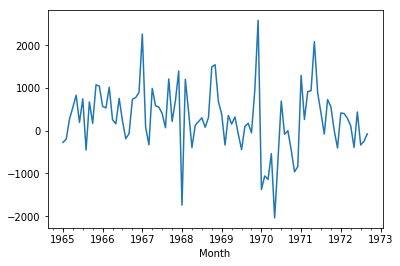

In [37]:
stationary.plot()

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.

We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

Note, we are now using the seasonally differenced stationary.csv as our dataset.

The example below creates ACF and PACF plots for the series.

/Users/amit.panda03/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


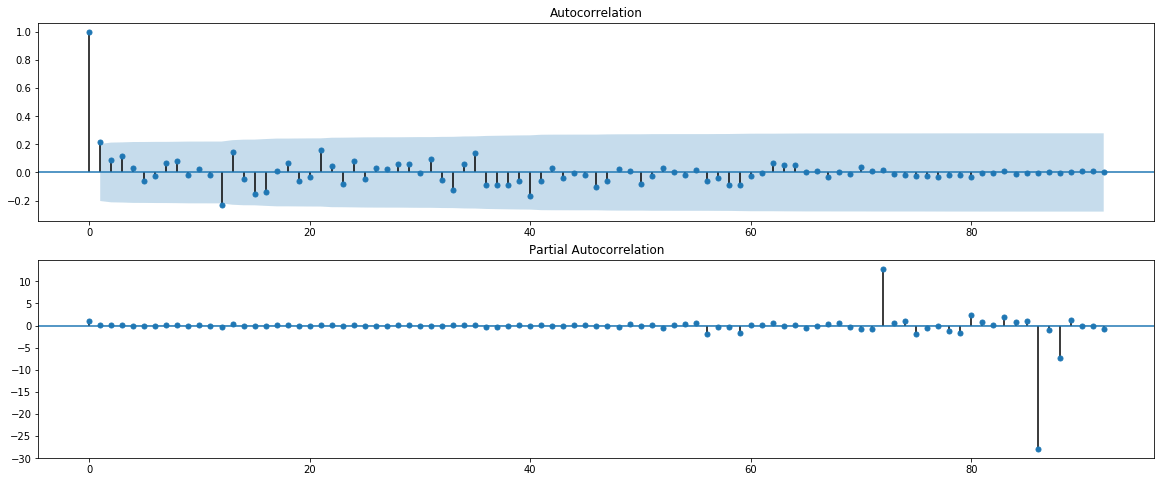

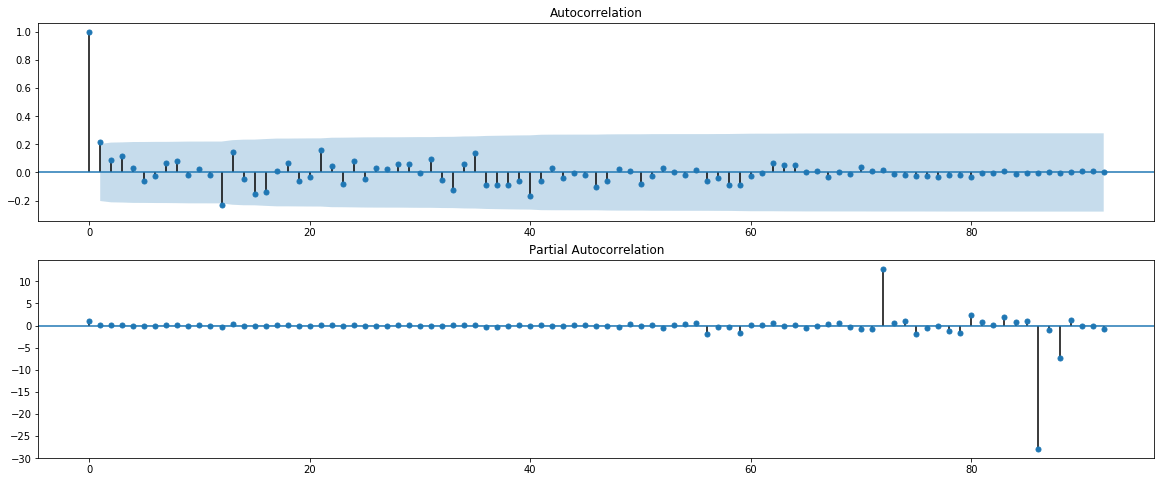

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt


plt.figure(figsize=(20,8))
plt.subplot(211)
plot_acf(stationary, ax=plt.gca())
plt.subplot(212)
plot_pacf(stationary, ax=plt.gca())

In [ ]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

## Grid search version to fing optimal p,d,q

In [ ]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)